In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
BATCH_SIZE = 5


# Define the transformations to apply to the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),    # Convert PIL image to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])    # Normalize the image



# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create a DataLoader to load the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create a DataLoader for the test data
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


# Define the classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

val_loader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Help Functions

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------

        self.act = nn.LeakyReLU()

        # input: 32x32x3
        self.c1 = nn.Conv2d(3, 3, kernel_size=3, padding=1) # output: 32x32x3 SAME
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x3 

        self.c2 = nn.Conv2d(3, 6, kernel_size=3, padding=1) # output: 16x16x6 SAME
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x6 
        
        self.c3 = nn.Conv2d(6, 12, kernel_size=3, padding=1) # output: 8x8x12 SAME
        
        self.fc1 = nn.Linear(in_features=8*8*12, out_features=60) 

        self.fc2 = nn.Linear(in_features=60, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)


    
    def forward(self, x):
        #Conv Layer 1
        x = self.c1(x)
        x = self.act(x)
        x = self.pool1(x)
        
        #Conv Layer 2        
        x = self.c2(x)
        x = self.act(x)
        x = self.pool2(x)

        #Conv Layer 3
        x = self.c3(x)
        x = self.act(x)

        #Flattening
        x = torch.flatten(x, 1)

        #FC Layer 1
        x = self.fc1(x)
        x = self.act(x)

        #FC Layer 2
        x = self.fc2(x)       
        
        #Softmax
        out = self.logSoftmax(x)

        return out
    

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1} of {num_epochs}")
        pbar = tqdm(total=len(train_loader), ncols=70, leave=False)
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            if batch_nr % len(train_loader)//5 == 0:
                pbar.update(len(train_loader)//5)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        pbar.close()
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cuda:0
Starting epoch 1 of 7


Starting epoch 2 of 7


Starting epoch 3 of 7


Starting epoch 4 of 7


Starting epoch 5 of 7


Starting epoch 6 of 7


Starting epoch 7 of 7


Test Loss: 0.2661, Test Accuracy: 52.38%
Confusion matrix, without normalization


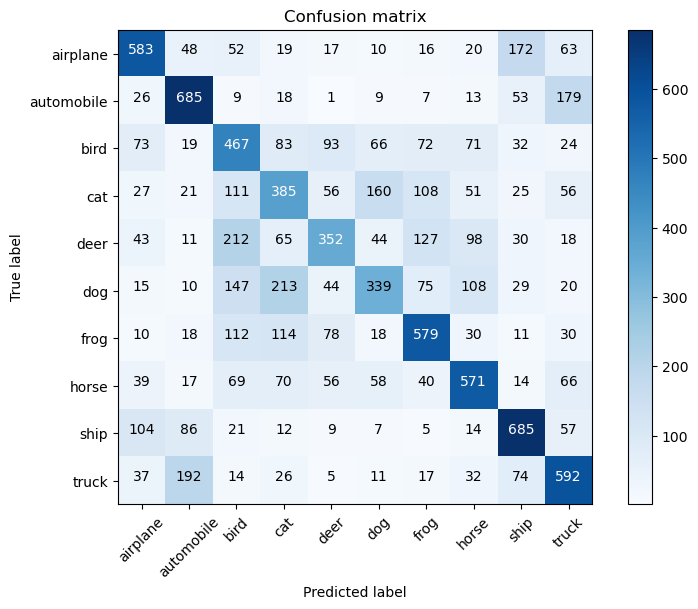

In [14]:
LEARNING_RATE = 0.0001
EPOCHS = 7

print(device)
model = CNN(num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
trained_model = train_model(model, criterion, optimizer, trainloader, val_loader, EPOCHS)
# Test the model
test_loss, test_accuracy, conf_matrix = test_model(trained_model, testloader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()